# About Dataset
The Mental Health Corpus is a collection of texts related to people with anxiety, depression, and other mental health issues. The corpus consists of two columns: one containing the comments, and the other containing labels indicating whether the comments are considered poisonous or not. The corpus can be used for a variety of purposes, such as sentiment analysis, toxic language detection, and mental health language analysis. The data in the corpus may be useful for researchers, mental health professionals, and others interested in understanding the language and sentiment surrounding mental health issues.

text: the comments  
labels: 1 means considered as a comment which is poisonous with mental health issues, and 0 means not considered.


In [64]:
# Importing necessary libraries
import pandas as pd             # For data manipulation and analysis
import numpy as np              # For numerical operations
from scipy import stats         # For statistical computations

import matplotlib.pyplot as plt # For plotting graphs
import seaborn as sns           # For data visualization

# Importing necessary libraries for model evaluation and training-test split.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Importing GridSearchCV from sklearn.model_selection for hyperparameter tuning.
from sklearn.model_selection import GridSearchCV

# Importing XGBClassifier and plot_importance from xgboost for gradient boosting.
from xgboost import XGBClassifier, plot_importance

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

from xgboost import DMatrix

In [41]:
import torch

In [42]:
print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cu121
True


In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
df0 = pd.read_csv("/content/drive/MyDrive/Projects/depression-and-anxiety-sentiment/mental_health.csv")

In [45]:
df0.head()

text  label
0  dear american teens question dutch person hear...      0
1  nothing look forward lifei dont many reasons k...      1
2  music recommendations im looking expand playli...      0
3  im done trying feel betterthe reason im still ...      1
4  worried  year old girl subject domestic physic...      1

In [46]:
df0.isna().sum()

text     0
label    0
dtype: int64

In [47]:
df0.duplicated().sum()

5

In [48]:
df0[df0.duplicated(keep=False)]

text  label
1646                 posting ara ara forget day  ara ara      0
11570                  real suppleroot hours  up day far      0
12573                  real suppleroot hours  up day far      0
15524  happy birthday everyone birthday st october ha...      0
16742  need help anyone good pythagriam tribometry  h...      0
22389                  real suppleroot hours  up day far      0
22603                posting ara ara forget day  ara ara      0
24502  happy birthday everyone birthday st october ha...      0
24970  need help anyone good pythagriam tribometry  h...      0

In [49]:
df = df0.drop_duplicates(keep = "first")

In [50]:
df.duplicated().sum()

0

In [51]:
def train_test_valid_split(df, target):

    y = df[target]
    X = df.drop(columns = [target])

    X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=65537)
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.25, stratify=y_train_temp, random_state=65537)
    return X_train, X_test, X_val, y_train, y_test, y_val, X, y


In [52]:
X_train, X_test, X_val, y_train, y_test, y_val, X, y = train_test_valid_split(df, target = "label")

In [53]:
dfs = [X_train, X_test, X_val, y_train, y_test, y_val]

In [54]:
for i in dfs:
    print(i.shape)

(16782, 1)
(5595, 1)
(5595, 1)
(16782,)
(5595,)
(5595,)


# CountVectorizer

In [55]:
# Set up a `CountVectorizer` object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 4),
                            max_features=2000,
                            stop_words='english',
                            lowercase=True)
count_vec

CountVectorizer(max_features=2000, ngram_range=(2, 4), stop_words='english')

In [56]:
%%time
# Wall time ~ 12.3 s
# Extract numerical features from `video_transcription_text` in the training set
count_data = count_vec.fit_transform(X_train["text"]).toarray()
count_data

CPU times: user 14.4 s, sys: 597 ms, total: 15 s
Wall time: 19.3 s


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [57]:
# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display first few rows
count_df.head()

able afford  able help  able live  able make  abusive relationship  \
0            0          0          0          0                     0   
1            0          0          0          0                     0   
2            0          0          0          0                     0   
3            0          0          0          0                     0   
4            0          0          0          0                     0   

   act like  acted like  acting like  actually really  actually want  ...  \
0         0           0            0                0              0  ...   
1         0           0            0                0              0  ...   
2         0           0            0                0              0  ...   
3         0           0            0                0              0  ...   
4         0           0            0                0              0  ...   

   years old  years really  years think  years time  years trying  \
0          0             0            0           0             0   
1          0             0            0           0             0   
2          0             0            0           0             0   
3          0             0            0           0             0   
4          0             0            0           0             0   

   years years  yes know  young age  young man  younger brother  
0            0         0          0          0                0  
1            0         0          0          0                0  
2            0         0          0          0                0  
3            0         0          0          0                0  
4            0         0          0          0                0  

[5 rows x 2000 columns]

In [58]:
# Concatenate `X_train` and `count_df` to form the final dataframe for training data (`X_train_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_train after dropping `video_transcription_text`,
# so that the indices align with those in `X_train` and `count_df`
X_train_final = pd.concat([X_train.drop(columns=["text"]).reset_index(drop=True), count_df], axis=1)

# Display first few rows
X_train_final.head()

able afford  able help  able live  able make  abusive relationship  \
0            0          0          0          0                     0   
1            0          0          0          0                     0   
2            0          0          0          0                     0   
3            0          0          0          0                     0   
4            0          0          0          0                     0   

   act like  acted like  acting like  actually really  actually want  ...  \
0         0           0            0                0              0  ...   
1         0           0            0                0              0  ...   
2         0           0            0                0              0  ...   
3         0           0            0                0              0  ...   
4         0           0            0                0              0  ...   

   years old  years really  years think  years time  years trying  \
0          0             0            0           0             0   
1          0             0            0           0             0   
2          0             0            0           0             0   
3          0             0            0           0             0   
4          0             0            0           0             0   

   years years  yes know  young age  young man  younger brother  
0            0         0          0          0                0  
1            0         0          0          0                0  
2            0         0          0          0                0  
3            0         0          0          0                0  
4            0         0          0          0                0  

[5 rows x 2000 columns]

In [59]:
# Extract numerical features from `video_transcription_text` in the testing set
validation_count_data = count_vec.transform(X_val["text"]).toarray()
validation_count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [60]:
# Place the numerical representation of `video_transcription_text` from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

able afford  able help  able live  able make  abusive relationship  \
0            0          0          0          0                     0   
1            0          0          0          0                     0   
2            0          0          0          0                     0   
3            0          0          0          0                     0   
4            0          0          0          0                     0   

   act like  acted like  acting like  actually really  actually want  ...  \
0         0           0            0                0              0  ...   
1         0           0            0                0              0  ...   
2         0           0            0                0              0  ...   
3         0           0            0                0              0  ...   
4         0           0            0                0              0  ...   

   years old  years really  years think  years time  years trying  \
0          0             0            0           0             0   
1          0             0            0           0             0   
2          0             0            0           0             0   
3          0             0            0           0             0   
4          0             0            0           0             0   

   years years  yes know  young age  young man  younger brother  
0            0         0          0          0                0  
1            0         0          0          0                0  
2            0         0          0          0                0  
3            0         0          0          0                0  
4            0         0          0          0                0  

[5 rows x 2000 columns]

In [61]:
# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
# Note: Using `.reset_index(drop=True)` to reset the index in X_val after dropping `video_transcription_text`,
# so that the indices align with those in `validation_count_df`
X_val_final = pd.concat([X_val.drop(columns=["text"]).reset_index(drop=True), validation_count_df], axis=1)

# Display first few rows
X_val_final.head()

able afford  able help  able live  able make  abusive relationship  \
0            0          0          0          0                     0   
1            0          0          0          0                     0   
2            0          0          0          0                     0   
3            0          0          0          0                     0   
4            0          0          0          0                     0   

   act like  acted like  acting like  actually really  actually want  ...  \
0         0           0            0                0              0  ...   
1         0           0            0                0              0  ...   
2         0           0            0                0              0  ...   
3         0           0            0                0              0  ...   
4         0           0            0                0              0  ...   

   years old  years really  years think  years time  years trying  \
0          0             0            0           0             0   
1          0             0            0           0             0   
2          0             0            0           0             0   
3          0             0            0           0             0   
4          0             0            0           0             0   

   years years  yes know  young age  young man  younger brother  
0            0         0          0          0                0  
1            0         0          0          0                0  
2            0         0          0          0                0  
3            0         0          0          0                0  
4            0         0          0          0                0  

[5 rows x 2000 columns]

In [62]:
# Extract numerical features from `video_transcription_text` in the testing set
test_count_data = count_vec.transform(X_test["text"]).toarray()

# Place the numerical representation of `video_transcription_text` from test set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())

# Concatenate `X_val` and `validation_count_df` to form the final dataframe for training data (`X_val_final`)
X_test_final = pd.concat([X_test.drop(columns=["text"]
                                      ).reset_index(drop=True), test_count_df], axis=1)
X_test_final.head()

able afford  able help  able live  able make  abusive relationship  \
0            0          0          0          0                     0   
1            0          0          0          0                     0   
2            0          0          0          0                     0   
3            0          0          0          0                     0   
4            0          0          0          0                     0   

   act like  acted like  acting like  actually really  actually want  ...  \
0         0           0            0                0              0  ...   
1         0           0            0                0              0  ...   
2         0           0            0                0              0  ...   
3         0           0            0                0              0  ...   
4         0           0            0                0              0  ...   

   years old  years really  years think  years time  years trying  \
0          0             0            0           0             0   
1          0             0            0           0             0   
2          0             0            0           0             0   
3          0             0            0           0             0   
4          0             0            0           0             0   

   years years  yes know  young age  young man  younger brother  
0            0         0          0          0                0  
1            0         0          0          0                0  
2            0         0          0          0                0  
3            0         0          0          0                0  
4            0         0          0          0                0  

[5 rows x 2000 columns]

In [73]:
# Creating an XGBoost classifier with binary logistic objective and setting random state to 65537.
xgb_cls = XGBClassifier(
    objective='binary:logistic',
    random_state=65537,
    device='cuda',
    tree_method='hist'
)

In [74]:
# Defining the grid of parameters for XGBoost classifier tuning.
cv_params = {
    'max_depth': [4, 8, 12],
    'min_child_weight': [1, 2],
    'learning_rate': [0.2, 0.4, 0.6],
    'n_estimators': [50, 100, 200, 400]
}

In [75]:
# Defining the scoring metrics to be used in GridSearchCV for XGBoost classifier.
scoring = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

In [76]:
# Creating a GridSearchCV object xgb for XGBoost classifier tuning.
xgb = GridSearchCV(xgb_cls, cv_params, scoring=scoring, cv=5, refit='roc_auc')

In [80]:
%%time
# Fit the model
# Wall time ~ 32min 59s

xgb.fit(X_train_final, y_train)

TypeError: Singleton array array(<xgboost.core.DMatrix object at 0x79f49c7f1c30>, dtype=object) cannot be considered a valid collection.

In [29]:
import os
import pickle

def write_pickle(path, model_object, save_as:str):
    '''
    In:
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''
    if not os.path.exists(path):
        os.makedirs(path)
    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

def read_pickle(path, saved_model_name:str):
    '''
    In:
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out:
        model: the pickled model
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [30]:
path = "/content/drive/MyDrive/Projects/depression-and-anxiety-sentiment/model_objects/"

In [31]:
# To write
write_pickle(path, xgb, 'xgb')

In [81]:
# To read
xgb = read_pickle(path, 'xgb')

In [82]:
xgb.best_score_, xgb.best_params_

(0.8972465235303669,
 {'learning_rate': 0.2,
  'max_depth': 12,
  'min_child_weight': 1,
  'n_estimators': 400})

In [83]:
y_val_pred = xgb.best_estimator_.predict(X_val_final)

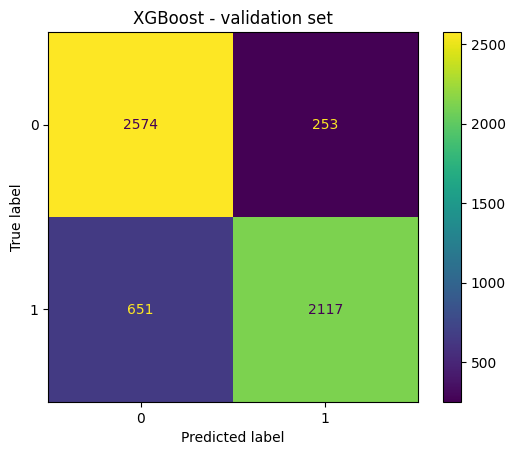

In [84]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_val, y_val_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('XGBoost - validation set');
plt.show()


In [85]:
# Create a classification report
target_labels = ["not poisonous", "poisonous"]
print(classification_report(y_val, y_val_pred, target_names=target_labels))

# Compute and print ROC-AUC score
roc_auc = roc_auc_score(y_val, y_val_pred)  # Adjust y_pred based on your predictions
print(f"ROC-AUC Score: {roc_auc:.4f}")

               precision    recall  f1-score   support

not poisonous       0.80      0.91      0.85      2827
    poisonous       0.89      0.76      0.82      2768

     accuracy                           0.84      5595
    macro avg       0.85      0.84      0.84      5595
 weighted avg       0.85      0.84      0.84      5595

ROC-AUC Score: 0.8377


Weight: Shows how many times each feature is used to split the data across all trees.  
Gain: Measures the improvement in accuracy brought by a feature to the branches it is on.  
Cover: Indicates the relative quantity of observations concerned by a feature.

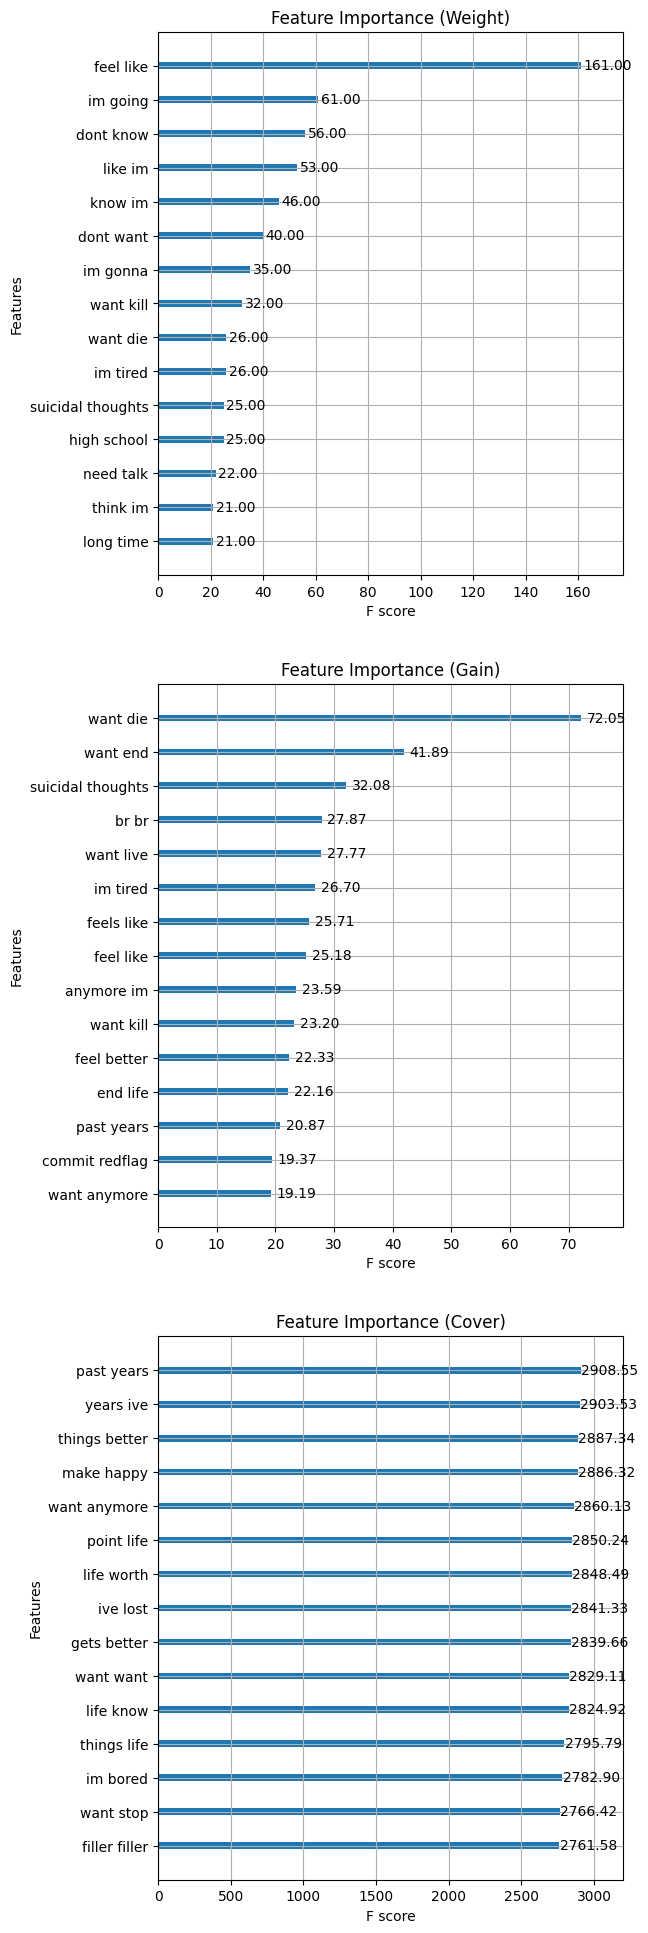

In [86]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

fig, ax = plt.subplots(3, 1, figsize=(6, 24))

# Weight
plot_importance(xgb.best_estimator_, importance_type='weight', ax=ax[0], title='Feature Importance (Weight)', max_num_features=15, values_format = "{v:.2f}")

# Gain
plot_importance(xgb.best_estimator_, importance_type='gain', ax=ax[1], title='Feature Importance (Gain)', max_num_features=15, values_format = "{v:.2f}")

# Cover
plot_importance(xgb.best_estimator_, importance_type='cover', ax=ax[2], title='Feature Importance (Cover)', max_num_features=15, values_format = "{v:.2f}")

plt.show()


In [87]:
# Initialize the model_scores DataFrame
model_scores = pd.DataFrame(columns=["Model", "Precision", "Recall", "Accuracy", "F1", "roc_auc"])

def get_scores(model_name, y_test, y_pred, model_scores):
    """
    Compute evaluation metrics and append to model_scores DataFrame.

    Parameters:
    - model_name: Name of the model.
    - y_test: True labels.
    - y_pred: Predicted labels from the model.
    - model_scores: DataFrame to append scores.

    Returns:
    - Updated model_scores DataFrame.
    """
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    # Create DataFrame with scores for the current model
    scores_df = pd.DataFrame([[model_name, precision, recall, accuracy, f1, roc_auc]],
                             columns=["Model", "Precision", "Recall", "Accuracy", "F1", "roc_auc"])

    # Append scores to model_scores DataFrame
    model_scores = pd.concat([model_scores, scores_df], ignore_index=True)

    return model_scores

In [88]:
# Update the model_scores DataFrame
model_scores = get_scores(model_name = "CountVectorizer XGB val", y_test = y_val, y_pred= y_val_pred, model_scores = model_scores)

In [89]:
model_scores

Model  Precision    Recall  Accuracy        F1   roc_auc
0  CountVectorizer XGB val   0.893249  0.764812  0.838427  0.824056  0.837659

# Transformers and BERT